In [1]:
# %%
%load_ext autoreload
%autoreload 2
#%%
import os
from os.path import join
import re
import math
import time
import glob
import pickle as pkl
from PIL import Image
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from neuro_data_analysis.mat_data_translate_lib import h5_to_dict_simplify, print_hdf5_info
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from core.utils.plot_utils import saveallforms
from core.utils.colormap_matlab import parula, viridis

# set the pandas display options width
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

mat_root = r"S:\Data-Ephys-MAT"
pkl_root = r"S:\Data-Ephys-PKL"
exp_record_pathdict = {"Alfa": r"S:\Exp_Record_Alfa.xlsx", 
                       "Beto": r"S:\ExpSpecTable_Augment.xlsx",
                       "Caos": r"S:\Exp_Record_Caos.xlsx",
                       "Diablito": r"S:\Exp_Record_Diablito.xlsx"}

#%% Main analysis pipeline
from neuro_data_analysis.neural_tuning_analysis_lib import organize_unit_info, maybe_add_unit_id_to_meta, \
    calculate_neural_responses, parse_stim_info, find_full_image_paths, load_space_images
from core.utils.montage_utils import PIL_array_to_montage, PIL_array_to_montage_score_frame
from core.utils.dataset_utils import ImagePathDataset
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ExpRecord_Hessian_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_tuning_ABCD_w_meta.csv")
ExpRecord_Evol_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_Evol_ABCD_w_meta.csv")
figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
# figdir = join(figroot, "Beto-07092020-003")
tuning_fitting_stats_synopsis = []
# ExpRecord_Hessian_All = ExpRecord_Hessian_All.sort_values(by=["Animal", "Expi"]).reset_index(drop=True)
for rowi, exprow in tqdm(ExpRecord_Hessian_All.iterrows()):
    print("Processing: row", rowi, exprow.ephysFN, exprow.Animal, exprow.Expi)
    figdir = join(figroot, exprow.ephysFN)
    sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
    tuning_fitting_stats = pkl.load(open(join(figdir, f"tuning_fitting_stats.pkl"), "rb"))
    tuning_fitting_stats_synopsis.extend(tuning_fitting_stats)



1it [00:00,  6.06it/s]

Processing: row 0 Caos-12022024-003 Caos 1.0
Processing: row 1 Caos-12022024-006 Caos 2.0
Processing: row 2 Caos-12042024-003 Caos 3.0
Processing: row 3 Caos-12042024-007 Caos 4.0
Processing: row 4 Caos-12092024-004 Caos 5.0
Processing: row 5 Caos-12102024-003 Caos 6.0
Processing: row 6 Caos-12102024-006 Caos 7.0


17it [00:00, 39.06it/s]

Processing: row 7 Diablito-03122024-003 Diablito 1.0
Processing: row 8 Diablito-11122024-003 Diablito 2.0
Processing: row 9 Diablito-11122024-005 Diablito 3.0
Processing: row 10 Diablito-12122024-004 Diablito 4.0
Processing: row 11 Diablito-12122024-006 Diablito 5.0
Processing: row 12 Alfa-04082020-003 Alfa 1.0
Processing: row 13 Alfa-06082020-004 Alfa 2.0
Processing: row 14 Alfa-10082020-004 Alfa 2.0
Processing: row 15 Alfa-12082020-004 Alfa 3.0
Processing: row 16 Alfa-14082020-003 Alfa 4.0
Processing: row 17 Alfa-25082020-007 Alfa 5.0
Processing: row 18 Alfa-27082020-003 Alfa 6.0
Processing: row 19 Alfa-01092020-004 Alfa 7.0
Processing: row 20 Alfa-02092020-004 Alfa 8.0
Processing: row 21 Alfa-02092020-006 Alfa 9.0
Processing: row 22 Alfa-08092020-004 Alfa 10.0
Processing: row 23 Alfa-11092020-003 Alfa 11.0
Processing: row 24 Alfa-11092020-006 Alfa 12.0
Processing: row 25 Alfa-16092020-003 Alfa 13.0


37it [00:00, 68.67it/s]

Processing: row 26 Alfa-16092020-005 Alfa 14.0
Processing: row 27 Alfa-27102020-007 Alfa 15.0
Processing: row 28 Alfa-27102020-008 Alfa 15.0
Processing: row 29 Alfa-27102020-009 Alfa 15.0
Processing: row 30 Alfa-04112020-005 Alfa 16.0
Processing: row 31 Alfa-06112020-006 Alfa 17.0
Processing: row 32 Alfa-12012021-003 Alfa 18.0
Processing: row 33 Alfa-13012021-003 Alfa 19.0
Processing: row 34 Alfa-19022021-004 Alfa 20.0
Processing: row 35 Alfa-25022021-004 Alfa 21.0
Processing: row 36 Alfa-26022021-005 Alfa 22.0
Processing: row 37 Alfa-12032021-005 Alfa 23.0
Processing: row 38 Alfa-01042021-004 Alfa 24.0
Processing: row 39 Alfa-08042021-003 Alfa 25.0
Processing: row 40 Alfa-14052021-004 Alfa 26.0
Processing: row 41 Beto-27072020-004 Beto 1.0
Processing: row 42 Beto-05082020-003 Beto 2.0
Processing: row 43 Beto-07082020-003 Beto 3.0
Processing: row 44 Beto-11082020-004 Beto 4.0


55it [00:00, 57.28it/s]

Processing: row 45 Beto-13082020-004 Beto 5.0
Processing: row 46 Beto-17082020-004 Beto 6.0
Processing: row 47 Beto-18082020-003 Beto 7.0
Processing: row 48 Beto-20082020-004 Beto 8.0
Processing: row 49 Beto-24082020-003 Beto 9.0
Processing: row 50 Beto-31082020-003 Beto 10.0
Processing: row 51 Beto-07092020-003 Beto 11.0
Processing: row 52 Beto-10092020-003 Beto 12.0
Processing: row 53 Beto-14092020-004 Beto 13.0
Processing: row 54 Beto-17092020-003 Beto 14.0


In [3]:
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)


In [5]:
pkl.dump(tuning_fitting_stats_synopsis, open(join(syndir, "tuning_shape_fitting_stats_synopsis.pkl"), "wb"))

In [6]:
tuning_fitting_stats_synopsis[0]

{'Animal': 'Caos',
 'Expi': 1.0,
 'ephysFN': 'Caos-12022024-003',
 'space': 'noise',
 'eig_id': 0,
 'x_values': array([ 0.4 ,  0.24,  0.32, -0.4 , -0.16,  0.32,  0.24, -0.24,  0.16,
        -0.32,  0.4 ,  0.  ,  0.32, -0.16,  0.4 ,  0.  ,  0.24, -0.32,
         0.16, -0.24, -0.4 , -0.32,  0.16, -0.24, -0.16, -0.4 ,  0.24,
         0.  ,  0.32,  0.4 , -0.16, -0.24,  0.  ,  0.32,  0.16,  0.4 ,
        -0.4 ,  0.24, -0.32,  0.24, -0.32,  0.32,  0.16,  0.4 ,  0.  ,
        -0.16, -0.4 , -0.24,  0.  , -0.4 , -0.32,  0.32,  0.24,  0.16,
         0.4 , -0.16, -0.24,  0.32,  0.24,  0.32,  0.4 , -0.32, -0.16,
         0.  , -0.24,  0.16, -0.4 ,  0.16, -0.4 , -0.16, -0.32,  0.24,
         0.  ,  0.4 , -0.24,  0.32,  0.16, -0.16,  0.24,  0.32, -0.32,
         0.4 , -0.4 , -0.24,  0.  , -0.4 ,  0.  ,  0.4 ]),
 'y_values': array([ 0.       , 13.319679 , 25.074692 , 19.979519 , 45.127415 ,
         6.659839 ,  6.659839 , 19.72635  , 19.726347 ,  0.       ,
        15.9846945, 13.39288  ,  6.659839 ,

In [26]:
tuning_fitting_stats_table = []
for entry in tuning_fitting_stats_synopsis:
    stats = {}
    for k in ["Animal", "Expi", "ephysFN", "space", "eig_id"]:
        stats[k] = entry[k]
    gauss_fit_results = entry["gauss_fit_results"]
    ols_fit_results = entry["ols_fit_results"]
    gpr_fit_results = entry["gpr_fit_results"]
    anova_results = entry["anova_results"]
    stats["x_values"] = entry["x_values"]
    stats["y_values"] = entry["y_values"]
    stats["anova_F_value"] = anova_results["F_value"]
    stats["anova_p_value"] = anova_results["p_value"]
    stats["anova_R2"] = compute_anova_R2(anova_results)
    stats["ols_R2"] = ols_fit_results['explained_variance']
    stats["ols_slope"] = ols_fit_results['params']['slope']
    stats["ols_intercept"] = ols_fit_results['params']['intercept']
    stats["gauss_R2"] = gauss_fit_results['explained_variance']
    if gauss_fit_results['params'] is not None:
        stats["gauss_fit_amplitude"] = gauss_fit_results['params'][0]
        stats["gauss_fit_center"] = gauss_fit_results['params'][1]
        stats["gauss_fit_sigma"] = gauss_fit_results['params'][2]
        stats["gauss_fit_offset"] = gauss_fit_results['params'][3]
    else:
        stats["gauss_fit_amplitude"] = np.nan
        stats["gauss_fit_center"] = np.nan
        stats["gauss_fit_sigma"] = np.nan
        stats["gauss_fit_offset"] = np.nan
    stats["gpr_R2"] = gpr_fit_results['explained_variance']
    stats["gpr_x_eval"] = gpr_fit_results['x_eval']
    stats["gpr_y_mean"] = gpr_fit_results['y_mean']
    stats["gpr_y_std"] = gpr_fit_results['y_std']
    tuning_fitting_stats_table.append(stats)
tuning_fitting_stats_table = pd.DataFrame(tuning_fitting_stats_table)
# tuning_fitting_stats_table.to_csv(join(syndir, "tuning_shape_fitting_stats_synopsis.csv"), index=False)
tuning_fitting_stats_table.to_pickle(join(syndir, "tuning_shape_fitting_stats_synopsis.pkl"))

In [19]:
tuning_fitting_stats_table.shape 

(1241, 16)

In [38]:
import numpy as np

def is_monotonic_np(y_values: np.ndarray, EPS: float = 0.01) -> bool:
    """
    Determines if the given NumPy array y_values is monotonic 
    (entirely non-increasing or non-decreasing).

    Args:
        y_values (np.ndarray): Sequence of numerical y-values.
        EPS (float): Tolerance for considering two values as equal (default is 0.01).

    Returns:
        bool: True if the sequence is monotonic, False otherwise.
    """
    if y_values.size <= 1:
        return True  # Empty or single-element sequences are monotonic

    diffs = np.diff(y_values)

    # Check for non-decreasing: all diffs >= -EPS
    non_decreasing = np.all(diffs >= -EPS)

    # Check for non-increasing: all diffs <= EPS
    non_increasing = np.all(diffs <= EPS)

    return non_decreasing or non_increasing


def is_unimodal_np(y_values: np.ndarray, EPS: float = 0.01) -> bool:
    """
    Determines if the given NumPy array y_values is unimodal 
    (has a single peak).

    Args:
        y_values (np.ndarray): Sequence of numerical y-values.
        EPS (float): Tolerance for considering two values as equal (default is 0.01).

    Returns:
        bool: True if the sequence is unimodal, False otherwise.
    """
    if y_values.size == 0:
        return False  # Empty sequence is not unimodal
    if y_values.size == 1:
        return True  # Single element is trivially unimodal

    # Find the index of the first occurrence of the maximum value
    peak_index = np.argmax(y_values)

    # Split the array into two parts: before and after the peak
    before_peak = y_values[:peak_index + 1]
    after_peak = y_values[peak_index:]

    # Compute differences for both parts
    diffs_before = np.diff(before_peak)
    diffs_after = np.diff(after_peak)

    # Check if the sequence before the peak is non-decreasing
    is_non_decreasing = np.all(diffs_before >= -EPS)

    # Check if the sequence after the peak is non-increasing
    is_non_increasing = np.all(diffs_after <= EPS)

    return is_non_decreasing and is_non_increasing

In [39]:
tuning_fitting_stats_table["gpr_y_is_unimodal"] = tuning_fitting_stats_table.apply(lambda row: is_unimodal_np(row["gpr_y_mean"]), axis=1)
tuning_fitting_stats_table["gpr_y_is_monotonic"] = tuning_fitting_stats_table.apply(lambda row: is_monotonic_np(row["gpr_y_mean"]), axis=1)

In [41]:
tuning_fitting_stats_table.query("anova_p_value < 0.001").groupby("eig_id").agg({"gpr_y_is_unimodal": "mean", "gpr_y_is_monotonic": ["mean", "count"]})

gpr_y_is_unimodal gpr_y_is_monotonic      
                    mean               mean count
eig_id                                           
0.0             0.552632           0.078947    38
1.0             0.685714           0.114286    35
2.0             0.406250           0.031250    32
3.0             0.468750           0.031250    32
4.0             0.444444           0.111111     9
5.0             0.400000           0.066667    15
6.0             0.583333           0.083333    24
8.0             0.636364           0.181818    11
9.0             0.555556           0.000000    18
10.0            0.555556           0.111111     9
11.0            1.000000           0.000000     1
13.0            0.600000           0.133333    15
15.0            0.500000           0.000000     2
17.0            0.363636           0.272727    11
19.0            1.000000           0.000000     1
20.0            0.470588           0.058824    17
21.0            0.750000           0.166667    12
25.0            0.800000           0.300000    10
30.0            0.560000           0.240000    25
40.0            0.523810           0.095238    21
60.0            0.666667           0.000000    12
70.0            0.000000           0.000000     1

In [42]:
tuning_fitting_stats_table["gpr_peak_x"] = tuning_fitting_stats_table.apply(lambda row: row["gpr_x_eval"][np.argmax(row["gpr_y_mean"])], axis=1)
tuning_fitting_stats_table["gpr_peak_y"] = tuning_fitting_stats_table.apply(lambda row: row["gpr_y_mean"][np.argmax(row["gpr_y_mean"])], axis=1)

In [47]:
tuning_fitting_stats_table['is_common_axis'] = tuning_fitting_stats_table.apply(lambda row: row['x_values'].max() == 0.4 and row['x_values'].min() == -0.4, axis=1)


<Axes: xlabel='eig_id', ylabel='gpr_y_is_unimodal'>

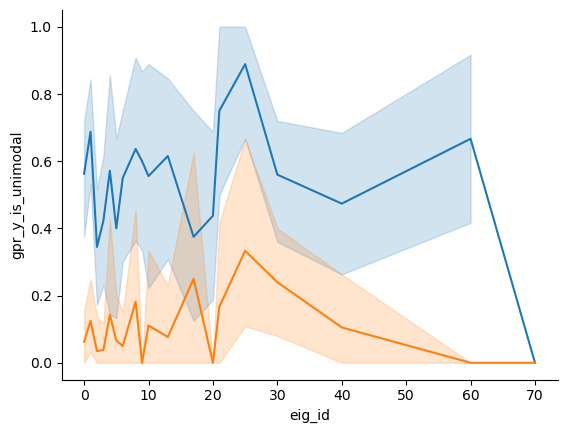

In [51]:
sns.lineplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="eig_id", y="gpr_y_is_unimodal")
sns.lineplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="eig_id", y="gpr_y_is_monotonic")


<Axes: xlabel='eig_id', ylabel='gpr_peak_x'>

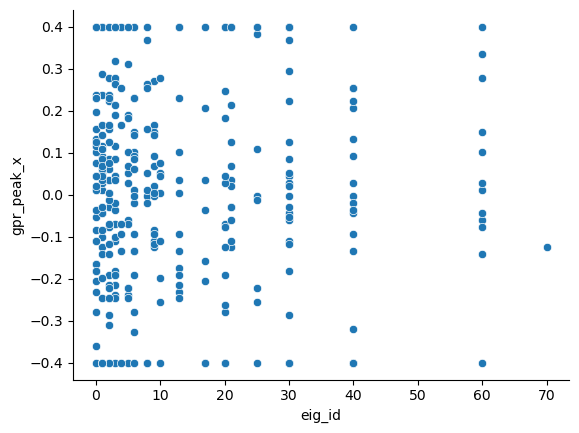

In [48]:
sns.scatterplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="eig_id", y="gpr_peak_x")


<Axes: xlabel='gauss_fit_center', ylabel='Count'>

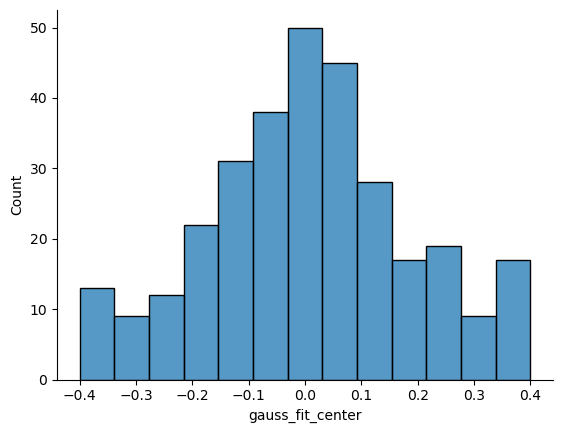

In [50]:
sns.histplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="gauss_fit_center")


<Axes: xlabel='gpr_peak_x', ylabel='Count'>

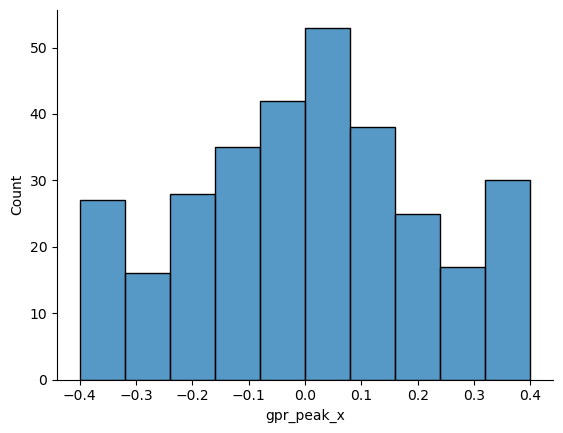

In [49]:
sns.histplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="gpr_peak_x")


In [ ]:
# write a funciton to test if gpr_y_mean is unimodal
def is_unimodal(y_values, EPS=0.01):
    return (np.mean(np.diff(y_values) >= 0) > (1 - EPS)) or (np.mean(np.diff(y_values) <= 0) > (1 - EPS))

# write a funciton to test if gpr_y_mean is monotonic increasing / decreasing
def is_monotonic(y_values, EPS=0.01):
    return (np.mean(np.diff(y_values) >= 0) > (1 - EPS)) or (np.mean(np.diff(y_values) <= 0) > (1 - EPS))
    # return np.all(np.diff(y_values) >= 0) or np.all(np.diff(y_values) <= 0)


<Axes: xlabel='eig_id', ylabel='gauss_fit_center'>

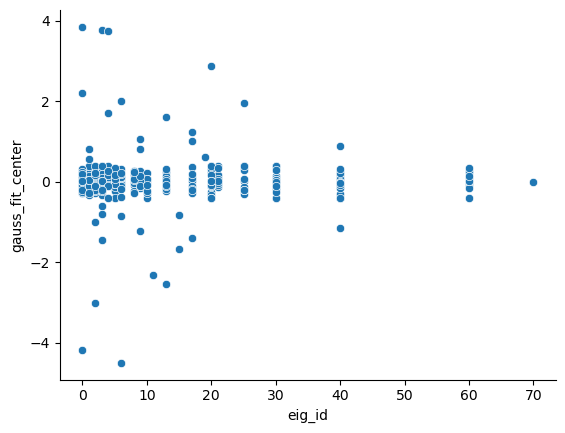

In [29]:
sns.scatterplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001"), x="eig_id", y="gauss_fit_center")


(-0.4, 0.4)

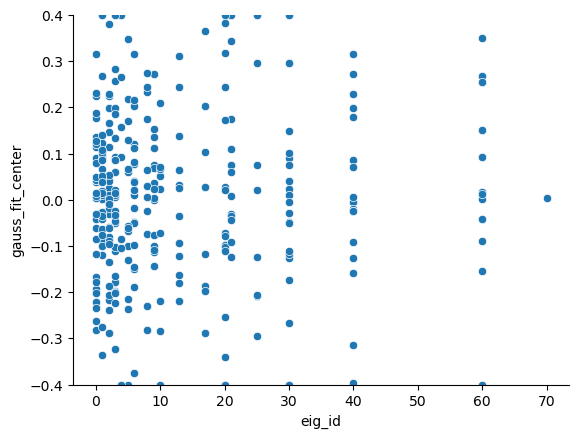

In [36]:
sns.scatterplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001"), x="eig_id", y="gauss_fit_center")
plt.ylim(-0.4, 0.4)

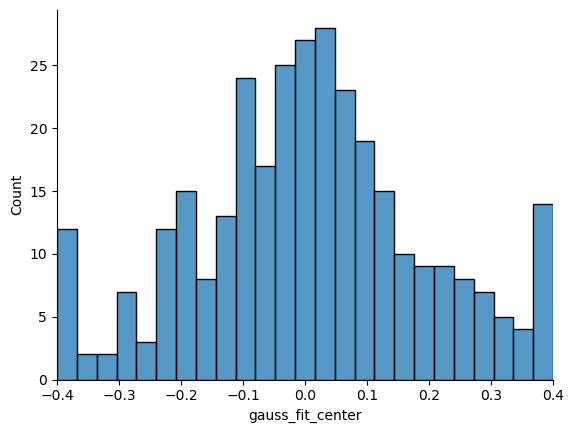

In [35]:
sns.histplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001"), x="gauss_fit_center", binrange=(-0.4, 0.4), bins=25)
plt.xlim(-0.4, 0.4)
plt.show()

### Hessian & Evolution joint analysis

In [ ]:
tuning_fitting_stats_table['Exp_id'] = tuning_fitting_stats_table.apply(lambda row: f"{row['Animal']}_{int(row['Expi'])}", axis=1)
evol_stats_synopsis_df['Exp_id'] = evol_stats_synopsis_df.apply(lambda row: f"{row['Animal']}_{int(row['Expi'])}", axis=1)

In [ ]:
sns.lineplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="eig_id", y="gpr_y_is_unimodal")
sns.lineplot(data=tuning_fitting_stats_table.query("anova_p_value < 0.001 and is_common_axis"), x="eig_id", y="gpr_y_is_monotonic")


### Scratch

In [21]:
gpr_fit_results

{'gpr': GaussianProcessRegressor(alpha=0.0,
                          kernel=31.7**2 * RBF(length_scale=0.08) + WhiteKernel(noise_level=76),
                          n_restarts_optimizer=10),
 'explained_variance': 0.1142897731625997,
 'x_eval': array([-0.4       , -0.39191919, -0.38383838, -0.37575758, -0.36767677,
        -0.35959596, -0.35151515, -0.34343434, -0.33535354, -0.32727273,
        -0.31919192, -0.31111111, -0.3030303 , -0.29494949, -0.28686869,
        -0.27878788, -0.27070707, -0.26262626, -0.25454545, -0.24646465,
        -0.23838384, -0.23030303, -0.22222222, -0.21414141, -0.20606061,
        -0.1979798 , -0.18989899, -0.18181818, -0.17373737, -0.16565657,
        -0.15757576, -0.14949495, -0.14141414, -0.13333333, -0.12525253,
        -0.11717172, -0.10909091, -0.1010101 , -0.09292929, -0.08484848,
        -0.07676768, -0.06868687, -0.06060606, -0.05252525, -0.04444444,
        -0.03636364, -0.02828283, -0.02020202, -0.01212121, -0.0040404 ,
         0.0040404 ,  0.

In [12]:
gauss_fit_results

{'params': array([21.05717319, -0.08744895,  0.0633959 ,  5.19787825]),
 'param_cov': array([[ 3.33686981e+02,  1.20092347e-01, -6.11783334e-01,
          4.50187877e+00],
        [ 1.20092347e-01,  1.47919468e-04, -2.21942549e-04,
          2.22192476e-03],
        [-6.11783334e-01, -2.21942549e-04,  1.20914170e-03,
         -1.37334863e-02],
        [ 4.50187877e+00,  2.22192476e-03, -1.37334863e-02,
          1.21471250e+00]]),
 'explained_variance': 0.19788100392567698}

In [11]:
ols_fit_results

{'params': {'slope': 1.9098530083361254, 'intercept': 7.335790822151475},
 'param_cov': None,
 'explained_variance': 0.0033997911065555275}

In [10]:
anova_results

{'F_value': 3.465323027173722,
 'p_value': 0.0017936847408128716,
 'stats_str': 'F-val: 3.47 | p-val: 1.8e-03',
 'anova_table':                   sum_sq    df         F    PR(>F)
 C(lin_dist)  1935.401754   8.0  3.465323  0.001794
 Residual     5515.241197  79.0       NaN       NaN,
 'error': None}

In [13]:
anova_results['anova_table']

,sum_sq,df,F,PR(>F)
C(lin_dist),1935.401754,8.0,3.465323,0.001794
Residual,5515.241197,79.0,NaN,NaN


In [15]:
res_ss = anova_results['anova_table'].loc['Residual','sum_sq']
lin_dist_ss = anova_results['anova_table'].loc['C(lin_dist)','sum_sq']
R2 = lin_dist_ss / (res_ss + lin_dist_ss)
print(R2)


0.25976305222257307


In [17]:
def compute_anova_R2(anova_results):
    if anova_results['anova_table'] is None:
        return np.nan
    res_ss = anova_results['anova_table'].loc['Residual','sum_sq']
    lin_dist_ss = anova_results['anova_table'].loc['C(lin_dist)','sum_sq']
    R2 = lin_dist_ss / (res_ss + lin_dist_ss)
    return R2

